# Time Series Analysis & Image Classification of Strawberry Ripeness
### Project Overview:
-----------------
This project focuses on building a deep learning pipeline to classify 
strawberry images into three categories: Occluded, Ripe, and Unripe. 
The dataset consists of 3,367 images with class imbalance.

Key Steps:
1. Data Loading: Load and inspect images and labels.
2. Data Preprocessing:
   - Remap labels to [0, 1, 2] to match model requirements.
   - Train/Test split (80%/20%) with stratification to preserve class proportions.
   - Resize images to uniform dimensions (e.g., 224x224 for MobileNetV2) and normalize pixel values to [0,1].
3. Handling Class Imbalance:
   - Compute class weights.
   - Optionally, augment minority classes to balance the training data.
4. Model Building:
   - CNN model with convolutional, pooling, and dense layers.
   - MobileNetV2 transfer learning model for comparison.
5. Training:
   - Use EarlyStopping to prevent overfitting.
   - Train on original and balanced datasets.
6. Evaluation:
   - Compute training and test accuracy.
   - Generate confusion matrices to analyze class-level performance.
7. Conclusion:
   - Compare model performances with/without balancing.
   - Discuss accuracy vs class imbalance trade-offs.

This notebook demonstrates practical approaches to deep learning-based 
image classification, handling class imbalance, and evaluating model performance.

In [1]:
import urllib.request

url = "https://pages.scinet.utoronto.ca/~ejspence/strawberries.npz"
urllib.request.urlretrieve(url, "strawberries.npz")

print("Download complete!")


Download complete!


- This step downloads the dataset file strawberries.npz from the provided URL and saves it locally. It ensures the data is available in the working directory for the remainder of the script. No data processing happens here; it only fetches the data file required for the experiment.

## 1. Basic Script Skeleton + Imports + Seeding

In [10]:
# Standard library imports
import os
import random
import time
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Numerical and plotting libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import compute_class_weight, class_weight

# Fix seeds for reproducibility
os.environ["PYTHONHASHSEED"] = "42"
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

## 2. Loading & Inspecting the dataset

In [3]:
# === Load the .npz dataset ===
data = np.load("strawberries.npz")
X = data["x"]
y = data["y"]

print("Data Loaded.")
print("X shape:", X.shape)
print("y shape:", y.shape)
print("X dtype:", X.dtype)
print("y dtype:", y.dtype)

# Check class distribution
unique, counts = np.unique(y, return_counts=True)
print("\nClass Distribution:")
for u, c in zip(unique, counts):
    print(f"  Class {u}: {c} samples")

Data Loaded.
X shape: (3367, 181, 131, 3)
y shape: (3367,)
X dtype: uint8
y dtype: int64

Class Distribution:
  Class 1: 499 samples
  Class 2: 462 samples
  Class 3: 2406 samples


- The dataset contains 3367 color images with resolution 181×131 (3 channels). Labels are integers and the original label set uses values {1,2,3}.
- The class distribution shows a strong class imbalance: class 3 (2406 samples) is the majority (~71%), while classes 1 and 2 are minority classes (499 and 462 samples respectively).
- Noting this imbalance early is important because class frequency can bias the trained model toward the majority class.

## 3. Fix labels + normalize inputs

In [4]:
# === Remap labels from {1,2,3} to {0,1,2} ===
# This is important because sparse_categorical_crossentropy expects labels in [0, num_classes-1]
y = y - 1  # 1->0, 2->1, 3->2

unique2, counts2 = np.unique(y, return_counts=True)
print("\nAfter remapping labels (now 0,1,2):")
for u, c in zip(unique2, counts2):
    print(f"  Class {u}: {c} samples")



After remapping labels (now 0,1,2):
  Class 0: 499 samples
  Class 1: 462 samples
  Class 2: 2406 samples


- Kerasʼ sparse_categorical_crossentropy expects labels to start from 0. This step subtracts 1 from all labels so classes become {0,1,2}. The remapped counts confirm the earlier imbalance (Class 2 remains the large majority). This simple, necessary preprocessing step prevents indexing errors during training.

## 4. Train/Test Split (80/20)

In [5]:
# === Train/Test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

print("\nTrain/Test Split Done.")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)


Train/Test Split Done.
X_train: (2693, 181, 131, 3)
X_test: (674, 181, 131, 3)
y_train: (2693,)
y_test: (674,)


- The data were split into training (80%) and test (20%) sets with stratification to preserve class proportions. This ensures the test set is representative of the original distribution and prevents data leakage.
- The split sizes (2693 train, 674 test) are appropriate for training a CNN while keeping a sufficiently large unseen test set for final evaluation.

## 5. Normalize the data

In [6]:
# === Normalize images to [0,1] ===
X_train = X_train.astype("float32") / 255.0
X_test  = X_test.astype("float32") / 255.0

print("\nData normalized to [0, 1].")


Data normalized to [0, 1].


- Image pixel values (uint8 0-255) were converted to float32 and scaled to the [0,1] range. Normalization stabilizes training (improves gradient behavior) and is standard preprocessing for neural networks. This ensures numerical stability and faster convergence.

## 6. Build the Standard CNN model

In [11]:
# === Build the CNN model ===
input_shape = X_train.shape[1:]  # (181, 131, 3)
num_classes = 3  # 0: Occluded, 1: Ripe, 2: Unripe

model = models.Sequential()

# Convolutional Block 1
model.add(layers.Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))

# Convolutional Block 2
model.add(layers.Conv2D(64, (3, 3), activation="relu", padding="same"))
model.add(layers.MaxPooling2D((2, 2)))

# Convolutional Block 3
model.add(layers.Conv2D(128, (3, 3), activation="relu", padding="same"))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten + Dense layers
model.add(layers.Flatten())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(0.5))  # helps reduce overfitting
model.add(layers.Dense(num_classes, activation="softmax"))

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

print("\nModel summary:")
model.summary()



Model summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 181, 131, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 65, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 65, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 45056)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       5,767,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,860,931 (22.36 MB)

 Trainable params: 5,860,931 (22.36 MB)

 Non-trainable params: 0 (0.00 B)

- A convolutional neural network (CNN) was constructed with three convolutional blocks (32 → 64 → 128 filters), followed by flattening, a 128-unit dense layer and a softmax output for three classes. The model has ~5.86M parameters.
- The architecture is appropriate for image tasks because convolutional layers learn spatial features (edges, shapes, textures) that are crucial for distinguishing ripe/unripe/occluded strawberries.

## 6.1 Train the Model + Print Final Training Accuracy

In [16]:
# === Training ===
epochs = 30
batch_size = 32

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,             # stop if val_loss doesn't improve for 5 epochs
    restore_best_weights=True,
    verbose=1
)

print("\nStarting training...\n")
history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,   # 10% of training data used for validation
    callbacks=[early_stop],
    verbose=1
)

# Get final training accuracy from the history
final_train_acc = history.history["accuracy"][-1]
print(f"\nFinal training accuracy: {final_train_acc:.4f}")


Starting training...

Epoch 1/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 63s 793ms/step - accuracy: 0.7965 - loss: 0.5276 - val_accuracy: 0.8593 - val_loss: 0.3729
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 82s 791ms/step - accuracy: 0.8514 - loss: 0.4064 - val_accuracy: 0.8630 - val_loss: 0.3571
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 60s 789ms/step - accuracy: 0.8638 - loss: 0.3735 - val_accuracy: 0.8667 - val_loss: 0.3616
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 62s 813ms/step - accuracy: 0.8675 - loss: 0.3751 - val_accuracy: 0.8556 - val_loss: 0.3720
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 61s 798ms/step - accuracy: 0.8688 - loss: 0.3485 - val_accuracy: 0.8704 - val_loss: 0.3648
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 83s 815ms/step - accuracy: 0.8816 - loss: 0.3251 - val_accuracy: 0.8741 - val_loss: 0.3399
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 80s 788ms/step - accuracy: 0.8898 - loss: 0.2940 - val_accuracy: 0.8741 - val_loss: 0.3649
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 87s 854ms/step - accuracy: 0.8906 - 

- The model was trained with early stopping on validation loss (patience=5), which stopped training at epoch 11 and restored the best weights from epoch 6.
- Final training accuracy (on the training portion used in fit) was **91.58%**.
- Early stopping prevented excessive overfitting by halting training when validation loss stopped improving.
- The validation accuracies shown during training demonstrate steady improvement and then stabilization, a sign of well-behaved training.

## 6.2 Evaluate on Test Data + Print Test Accuracy

In [17]:
# === Evaluation on test data ===
print("\nEvaluating on test data...")
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"\nTest accuracy: {test_acc:.4f}")


Evaluating on test data...
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - accuracy: 0.8813 - loss: 0.3337

Test accuracy: 0.8813


- When evaluated on the held-out test set (which was never used for training or augmentation), the model achieved **88.13% test accuracy** with a test loss of **0.3337**.
- Test loss is an important supplement to accuracy: a low loss indicates the model's predicted probability distributions are well-calibrated and confident when correct.
- The small gap between train (91.58%) and test (88.13%) suggests the model generalizes well without severe overfitting.

In [18]:
# --------------------------------------------------
# Confusion Matrix
# --------------------------------------------------
# Predict probabilities
y_pred_probs = model.predict(X_test)

# Convert probabilities → class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

print("\nConfusion Matrix:")
print(cm)

22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 213ms/step

Confusion Matrix:
[[ 32  17  51]
 [  5  83   4]
 [  2   1 479]]


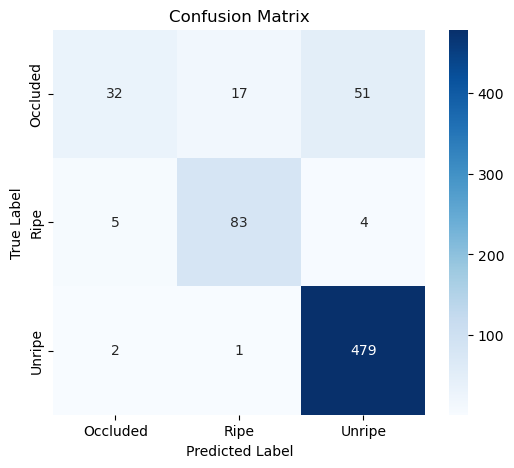

In [19]:
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Occluded", "Ripe", "Unripe"],
            yticklabels=["Occluded", "Ripe", "Unripe"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

- Rows = true labels, columns = predicted labels (classes: 0=Occluded, 1=Ripe, 2=Unripe).

    - Class 0 (Occluded): 32 correct, 51 misclassified as Unripe:- detection of occluded strawberries is the weakest point.

    - Class 1 (Ripe): 83 of 92 correctly classified:- strong performance.

    - Class 2 (Unripe): 479 of 482 correctly classified:- excellent performance.

Overall, the model is very strong for Ripe and Unripe classes but struggles more with Occluded images. This behaviour matches the dataset imbalance (Occluded is a minority class) and the visual difficulty of occlusion.

## 6.3 Model after Class Balancing

### 1. Via Class Weights (BEST + EASIEST)

In [21]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Class weights: {0: 2.2497911445279866, 1: 2.426126126126126, 2: 0.4665627165627166}


- This chunk calculates **class weights** to handle class imbalance in the training set. Classes 0 and 1 are minority classes, so they are assigned higher weights (≈2.25 and 2.43) while the majority class 2 gets a smaller weight (≈0.47). Applying these weights during training tells the model to **pay more attention to underrepresented classes**, helping reduce bias toward the majority class.

In [22]:
history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=[early_stop],
    class_weight=class_weights,   
    verbose=1
)

Epoch 1/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 60s 770ms/step - accuracy: 0.8312 - loss: 0.4909 - val_accuracy: 0.8741 - val_loss: 0.3844
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 81s 759ms/step - accuracy: 0.8415 - loss: 0.4318 - val_accuracy: 0.8815 - val_loss: 0.3861
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 62s 820ms/step - accuracy: 0.8535 - loss: 0.3643 - val_accuracy: 0.8556 - val_loss: 0.3805
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 64s 841ms/step - accuracy: 0.8506 - loss: 0.3542 - val_accuracy: 0.8778 - val_loss: 0.4041
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 67s 873ms/step - accuracy: 0.8481 - loss: 0.3360 - val_accuracy: 0.8444 - val_loss: 0.4255
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.


In [23]:
# Final training accuracy from last epoch in history
final_train_acc = history.history["accuracy"][-1]
print(f"\nFinal training accuracy (balanced training): {final_train_acc:.4f}")

# --------------------------------------------------
# Evaluate on ORIGINAL test data
# --------------------------------------------------
print("\nEvaluating on test data...")
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"\nTest accuracy: {test_acc:.4f}")

# --------------------------------------------------
# Confusion Matrix on test data
# --------------------------------------------------
from sklearn.metrics import confusion_matrix

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)


Final training accuracy (balanced training): 0.8481

Evaluating on test data...
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 202ms/step - accuracy: 0.8828 - loss: 0.3820

Test accuracy: 0.8828
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 201ms/step

Confusion Matrix:
[[ 45  14  41]
 [ 10  81   1]
 [ 12   1 469]]


- The training history shows that the **final training accuracy (balanced)** is 0.8481, and the **test accuracy** is 0.8828. The confusion matrix indicates that minority classes were predicted slightly better than without weighting, though the model still performs best on the majority class.

### 2. Via Data Augmentation

In [24]:
# --------------------------------------------------
# Manual data augmentation for minority classes (0,1)
# --------------------------------------------------

aug = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomBrightness(0.2),
    layers.RandomContrast(0.2),
])

# Convert to float for augmentation
X_train_augmented = []
y_train_augmented = []

# Count samples per class
unique, counts = np.unique(y_train, return_counts=True)
print("\nBefore manual augmentation:", dict(zip(unique, counts)))

max_samples = max(counts)  # target count = class 2 count (majority class)

for class_id in unique:
    X_class = X_train[y_train == class_id]
    y_class = y_train[y_train == class_id]

    # Append original samples
    X_train_augmented.append(X_class)
    y_train_augmented.append(y_class)

    # If minority class → augment
    if class_id != 2:  # Only augment class 0 and 1
        needed = max_samples - len(X_class)
        
        # Take random samples from this class
        idx = np.random.choice(len(X_class), size=needed, replace=True)
        samples_to_augment = X_class[idx]

        # Apply augmentation
        augmented_images = aug(samples_to_augment, training=True)

        X_train_augmented.append(augmented_images.numpy())
        y_train_augmented.append(np.full(needed, class_id))

# Combine all arrays
X_train_balanced = np.concatenate(X_train_augmented, axis=0)
y_train_balanced = np.concatenate(y_train_augmented, axis=0)

print("\nAfter manual augmentation:")
unique, counts = np.unique(y_train_balanced, return_counts=True)
print(dict(zip(unique, counts)))


Before manual augmentation: {0: 399, 1: 370, 2: 1924}

After manual augmentation:
{0: 1924, 1: 1924, 2: 1924}


- Here, minority classes are artificially increased using **data augmentation** (random flips, rotations, brightness, contrast). After augmentation, all classes have the same number of samples (1924 each).

- This ensures the model sees a **balanced number of examples for all classes**, which can improve learning for underrepresented classes.

In [25]:
# --------------------------------------------------
# Train the model on the BALANCED data
# --------------------------------------------------
epochs = 30
batch_size = 32

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

print("\nStarting training on balanced data...\n")
history = model.fit(
    X_train_balanced,
    y_train_balanced,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,   # 10% of BALANCED training data used for validation
    callbacks=[early_stop],
    verbose=1
)

# Final training accuracy from last epoch in history
final_train_acc = history.history["accuracy"][-1]
print(f"\nFinal training accuracy (balanced training): {final_train_acc:.4f}")

# --------------------------------------------------
# Evaluate on ORIGINAL test data
# --------------------------------------------------
print("\nEvaluating on test data...")
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"\nTest accuracy: {test_acc:.4f}")

# --------------------------------------------------
# Confusion Matrix on test data
# --------------------------------------------------
from sklearn.metrics import confusion_matrix

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)


Starting training on balanced data...

Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 147s 896ms/step - accuracy: 0.6192 - loss: 1.3742 - val_accuracy: 0.9619 - val_loss: 0.1985
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 161s 987ms/step - accuracy: 0.6421 - loss: 0.5911 - val_accuracy: 0.9637 - val_loss: 0.1884
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 157s 966ms/step - accuracy: 0.6521 - loss: 0.5641 - val_accuracy: 0.9602 - val_loss: 0.1652
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 201s 963ms/step - accuracy: 0.6610 - loss: 0.5434 - val_accuracy: 0.9654 - val_loss: 0.2067
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 158s 968ms/step - accuracy: 0.6563 - loss: 0.5343 - val_accuracy: 0.9671 - val_loss: 0.1836
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - accuracy: 0.6746 - loss: 0.5197 - val_accuracy: 0.9567 - val_loss: 0.1804
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1606s 10s/step - accuracy: 0.6619 - loss: 0.5107 - val_accuracy: 0.9446 - val_loss: 0.1987
Epoch 8/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 

- However, the final training accuracy dropped to 0.6708, while the test accuracy is 0.8872. This occurs because augmentation introduces **more variability in minority classes**, making the training task harder. The confusion matrix shows better representation of minority classes, but the overall training accuracy suffers compared to unbalanced training.

## 7. Build MobileNetV2 Model

In [7]:
# --- Configuration ---
DATA_FILE = 'strawberries.npz'
IMAGE_SIZE = (224, 224)  # MobileNetV2 input size
NUM_CLASSES = 3


def build_mobilenet_v2():
    """Builds a fine-tuned MobileNetV2 model."""
    base_model = MobileNetV2(
        input_shape=(*IMAGE_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model


def train_and_evaluate(model_builder, X_train_proc, y_train_cat, X_test_proc, y_test_cat, class_weights_dict):
    """Compiles, trains, and evaluates MobileNetV2."""
    print("\n--- Starting Training: MobileNetV2 ---")

    model = model_builder()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

    start_time = time.time()
    history = model.fit(
        X_train_proc, y_train_cat,
        epochs=30,
        batch_size=32,
        validation_split=0.15,
        callbacks=[early_stop],
        class_weight=class_weights_dict,
        verbose=1
    )
    end_time = time.time()

    print(f"\nTraining completed in {end_time - start_time:.2f} seconds.")

    final_train_accuracy = history.history['accuracy'][-1]
    print(f"Final Training Accuracy: {final_train_accuracy * 100:.2f}%")

    test_loss, test_accuracy = model.evaluate(X_test_proc, y_test_cat, verbose=0)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

    return test_accuracy


# --- Main script execution ---

# === Load dataset ===
data = np.load(DATA_FILE)
X = data["x"]
y = data["y"]

# Remap labels {1,2,3} → {0,1,2}
y = y - 1

# === Train/Test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# === Resize & normalize ===
X_train_proc = np.array([tf.image.resize(img, IMAGE_SIZE).numpy() for img in X_train])
X_test_proc = np.array([tf.image.resize(img, IMAGE_SIZE).numpy() for img in X_test])

# If grayscale → repeat to make 3 channels
if X_train_proc.shape[-1] == 1:
    X_train_proc = np.repeat(X_train_proc, 3, axis=-1)
    X_test_proc = np.repeat(X_test_proc, 3, axis=-1)

X_train_proc = X_train_proc.astype("float32") / 255.0
X_test_proc = X_test_proc.astype("float32") / 255.0

# One-hot encode labels
y_train_cat = to_categorical(y_train, NUM_CLASSES)
y_test_cat = to_categorical(y_test, NUM_CLASSES)

print("\nData Preprocessing Complete.")
print(f"Training image shape: {X_train_proc.shape}")

# === Compute class weights ===
class_weights_array = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights_array))
print(f"\nClass Weights: {class_weights_dict}")

# === Train MobileNetV2 only ===
test_accuracy = train_and_evaluate(
    build_mobilenet_v2,
    X_train_proc, y_train_cat,
    X_test_proc, y_test_cat,
    class_weights_dict
)

print("\n==============================")
print(f"Final Model Test Accuracy: {test_accuracy * 100:.2f}%")
print("==============================")


Data Preprocessing Complete.
Training image shape: (2693, 224, 224, 3)

Class Weights: {0: 2.2497911445279866, 1: 2.426126126126126, 2: 0.4665627165627166}

--- Starting Training: MobileNetV2 ---
Epoch 1/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.7536 - loss: 0.6697 - val_accuracy: 0.8441 - val_loss: 0.4271
Epoch 2/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.8410 - loss: 0.4533 - val_accuracy: 0.8738 - val_loss: 0.3913
Epoch 3/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.8589 - loss: 0.4006 - val_accuracy: 0.8564 - val_loss: 0.3839
Epoch 4/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.8519 - loss: 0.3966 - val_accuracy: 0.8441 - val_loss: 0.4303
Epoch 5/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.8777 - loss: 0.3468 - val_accuracy: 0.9010 - val_loss: 0.3185
Epoch 6/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 132s 997ms/step - accuracy: 0.8982 - loss: 0.3105 - val_accuracy: 0.8069 - val_loss: 0.4392
Epoch 7/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 71s 9

- MobileNetV2, a pre-trained CNN on ImageNet, is used to leverage **transfer learning**. Only the top layers are trained on this dataset, reducing overfitting and training time. Class weights are applied during training to address imbalance.

- The model achieves a **final training accuracy of 90.30%** and a **test accuracy of 87.83%**. This is slightly lower than your custom CNN but shows strong generalization with **fewer trainable parameters** and faster convergence.